In [1]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [49]:
from math import e
from math import sqrt

In [184]:
# Tree Drawing Function

import networkx as nx
import matplotlib.pyplot as plt

def add_edges(G, tree, parent=None, path=""):

    if tree is None:
        return

    value, left_sub, right_sub = tree

    node_id = (value, path)

    G.add_node(node_id, label=str(value))

    if parent is not None:
        G.add_edge(parent, node_id)

    add_edges(G, left_sub, node_id, path + "d")
    add_edges(G, right_sub, node_id, path + "u")

def hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):

    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.successors(root))
    if parent is not None and parent in neighbors:
        neighbors.remove(parent)
    if len(neighbors) != 0:
        dx = width / len(neighbors)
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap,
                                vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
    return pos

In [157]:
# Up/Down Parameter calculator:

def calc_Up(volatility, step_len):
    
    return(e ** (volatility * sqrt(step_len)))

def calc_Down(volatility, step_len):
    
    return(1/calc_Up(volatility, step_len))

In [158]:
# Draw Stock Price Tree:

def BT_Spot(u, d, S0, steps, curr_step = 0, num_up = 0, num_down = 0):

    ''' u/d: parameters of underlying asset go up/down at next timespot
        S0: Initial Spot Price
        steps: # of steps in this tree. Positive Integer 1,2,3,4,...
        curr_step: Current Step in the tree
        num_up/down: how many times up / down for current node
    '''
        
    price = round((S0 * (u ** num_up) * (d ** num_down)), 3)
    
    if curr_step == steps:
        return[price, None, None]
    
    down_subtree = BT_Spot(u, d, S0, steps, curr_step + 1, num_up, num_down + 1) # Downside Tree
    up_subtree = BT_Spot(u, d, S0, steps, curr_step + 1, num_up + 1, num_down) #Upside Tree
    
    return [price, up_subtree, down_subtree]

In [170]:
# Draw Option Price Tree:

# Assume we have this binary tree looped list get by function above:
#w = [50.0, [60.0, [72.0, [86.4, [103.68, None, None], [69.12, None, None]], [57.6, [69.12, None, None], [46.08, None, None]]], [48.0, [57.6, [69.12, None, None], [46.08, None, None]], [38.4, [46.08, None, None], [30.72, None, None]]]], [40.0, [48.0, [57.6, [69.12, None, None], [46.08, None, None]], [38.4, [46.08, None, None], [30.72, None, None]]], [32.0, [38.4, [46.08, None, None], [30.72, None, None]], [25.6, [30.72, None, None], [20.48, None, None]]]]]

def get_final_value(tree):
    '''
        tree: the asset pricing tree list
    '''
    
    if tree is None: # if the list input is blank, return a blank listy
        return []
    
    value, up_sub, down_sub = tree # Since tree is a looped list with 3 elements, build 3 variables stand for them
    
    if up_sub is None and down_sub is None:
        return[value]
    return get_final_value(up_sub) + get_final_value(down_sub)

#finalLeaf = list(set(get_final_value(w))) # Delete repetitive numbers in the list
#clearList = sorted(finalLeaf, reverse=True) # Make the list returned sorted from large to small
#print(clearList)

def BT_Option(leafList, K, EU_US, step_len, rate, put_call, u, d, Asset_Category, q):
    '''
        Asset_Category: 1 -> non-dividend stock, 2 -> dividend bearing stock/index/FX, 3 -> Future
        q: dividend % or FX risk free rate
    '''
    if Asset_Category == 1:
        p = (e ** (rate * step_len) - d) / (u - d) # calculate risk-neutral probability. U and D grabbed from above function.
        
    elif Asset_Category == 2:
        p = (e ** ((rate - q) * step_len) - d) / (u - d)
        
    elif Asset_Category == 3:
        p = (1 - d) / (u - d)
        
    
    if EU_US: # True: EU Option
        
        if put_call: # True: Call Option
        
            option_Price_List = []
            step_List = []
            
            for i in leafList: 
                
                if K >= i:
                    step_List.append(0)
                else:
                    step_List.append(round((i - K), 3))
                    
            option_Price_List.append(step_List)
            
            button = steps 
            while button > 0:
                
                temp_list = []
                for i in range(len(step_List) - 1):
                    
                    optionP = (p * step_List[i] + (1 - p) * step_List[i + 1]) * e ** (-rate * step_len)
                    #optionP = e**(-rate * step_len) * ( p * step_List[i + 1] + (1 - p) * step_List[i] )
                    temp_list.append(round(optionP, 3))

                option_Price_List.append(temp_list.copy())
                step_List = temp_list
                button -= 1
                
            option_Price_List.reverse()
            return(option_Price_List)
        
        else: # False: Put Option
            
            option_Price_List = []
            step_List = []
            
            for i in leafList: 
                
                if K <= i:
                    step_List.append(0)
                else:
                    step_List.append(round((K - i), 3))
                    
            option_Price_List.append(step_List)
            
            button = steps 
            while button > 0:
                
                temp_list = []
                for i in range(len(step_List) - 1):
                    
                    optionP = (p * step_List[i] + (1 - p) * step_List[i + 1]) * e ** (-rate * step_len)
                    #optionP = e**(-rate * step_len) * ( p * step_List[i + 1] + (1 - p) * step_List[i] )
                    temp_list.append(round(optionP, 3))

                option_Price_List.append(temp_list.copy())
                step_List = temp_list
                button -= 1
                
            option_Price_List.reverse()
            return(option_Price_List)
    
    else: # False: US Option
        
        if put_call: # True: US Call Option (Same As EU Call)
            
            option_Price_List = []
            step_List = []
            
            for i in leafList: 
                
                if K >= i:
                    step_List.append(0)
                else:
                    step_List.append(round((i - K), 3))
                    
            option_Price_List.append(step_List)
            
            button = steps 
            while button > 0:
                
                temp_list = []
                for i in range(len(step_List) - 1):
                    
                    optionP = (p * step_List[i] + (1 - p) * step_List[i + 1]) * e ** (-rate * step_len)
                    #optionP = e**(-rate * step_len) * ( p * step_List[i + 1] + (1 - p) * step_List[i] )
                    temp_list.append(round(optionP, 3))

                option_Price_List.append(temp_list.copy())
                step_List = temp_list
                button -= 1
                
            option_Price_List.reverse()
            return(option_Price_List)
            
        else: # False: US Put Option (WARNING: This function is temp, Not getting the idea of US Put yet, WAIT for SOLVE)
            
            option_Price_List = []
            step_List = []
            
            for i in leafList: 
                
                if K <= i:
                    step_List.append(0)
                else:
                    step_List.append(round((K - i), 3))
                    
            option_Price_List.append(step_List)
            
            button = steps
            while button > 0:
                
                temp_list = []
                for i in range(len(step_List) - 1):
                    
                    optionP = (p * step_List[i] + (1 - p) * step_List[i + 1]) * e ** (-rate * step_len)
                    #optionP = e**(-rate * step_len) * ( p * step_List[i + 1] + (1 - p) * step_List[i] )
                    temp_list.append(round(optionP, 3))

                option_Price_List.append(temp_list.copy())
                step_List = temp_list
                button -= 1
                
            option_Price_List.reverse()
            return(option_Price_List)
                       
#BT_Option(clearList, 60, True, 0.5, 0.05, True, 1.2, 0.8, 1, 0)    

In [160]:
# Change the output format into tree-available format:

def BT_Generate_Option(option_Price_List): 
    
    if not option_Price_List:
        return None # Return None when input None
    
    def helper(row, col):
        tree = option_Price_List[row][col]
        if row == len(option_Price_List) - 1: # When the 'row' variable hit the last row, it means the node is a leaf.
            return[tree, None, None] # Return leaf list
        
        up_subtree = helper(row + 1, col)
        down_subtree = helper(row + 1, col + 1)
        return [tree, up_subtree, down_subtree]
    
    return helper(0,0)
    
# Test
#print(BT_Generate_Option([[6.555], [10.759, 1.512], [17.451, 2.752, 0.0], [27.881, 5.01, 0.0, 0.0], [43.68, 9.12, 0, 0, 0]]))

Binary Tree Option Pricing Model v1.0 

Please choose the mode:
 [1] for known Up/Down parameters
 [2] for known historical volatility of underlying asset2
You want to evaluate EU or US option? [1] for EU, [0] for US: 
1
You want to evaluate Put or Call option? [1] for Call, [0] for Put: 
1
The underlying asset is
 [1] Non-Dividend Stock
 [2] Dividend Bearing Stock, Index, FX
 [3] Future
1
Historical Volatility of Underlying Asset: 
0.3
Asset Spot Price (S0): 
78
Strike Price (K): 
80
Total Steps of the Tree: 
 2
Step Length in Year: 
0.166667
Risk-free Rate (Annual, Comp. Cont.): 
0.03


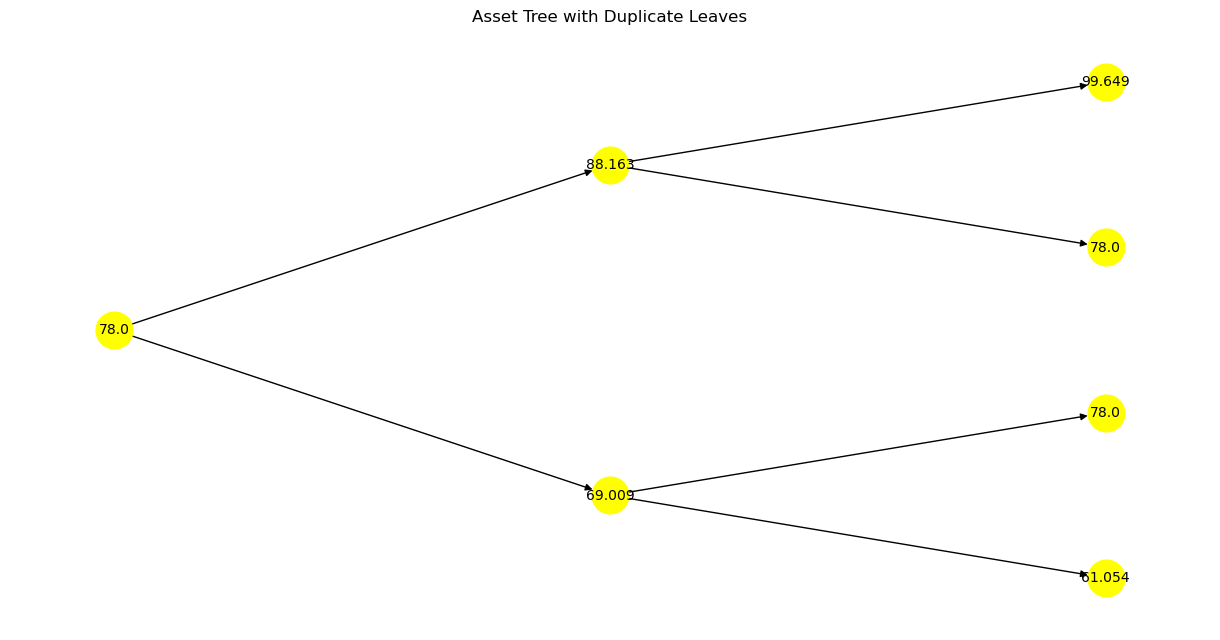

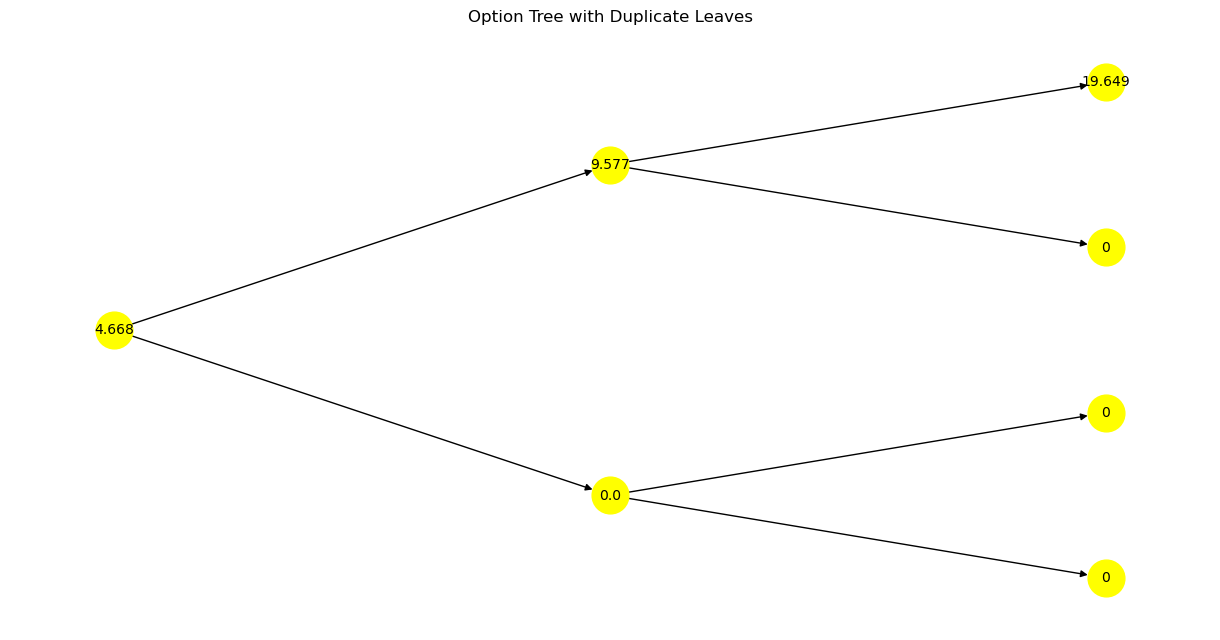

Exit? Y/Ny


In [191]:
# Users Terminal

ctrl = True

while ctrl:
    print('Binary Tree Option Pricing Model v1.0 \n')
    modeChoice = input('Please choose the mode:\n [1] for known Up/Down parameters\n [2] for known historical volatility of underlying asset')
    
    if modeChoice == '1':
        
        EU_US = bool(int(input('You want to evaluate EU or US option? [1] for EU, [0] for US: \n')))
        put_call = bool(int(input('You want to evaluate Put or Call option? [1] for Call, [0] for Put: \n')))
        Asset_Category = int(input('The underlying asset is\n [1] Non-Dividend Stock\n [2] Dividend Bearing Stock, Index, FX\n [3] Future\n'))
        if Asset_Category == 2:
            q = float(input('Dividend Rate (if you are calculating Dividend bearing stock or Index)\n or Foreign Risk-free Rate (if you are calculating FX)\n'))
        else:
            q = 0
        up = float(input('Up parameter (u): \n'))
        down = float(input('Down parameter (d): \n'))
        S0 = float(input('Asset Spot Price (S0): \n'))
        K = float(input('Strike Price (K): \n'))
        steps = int(input('Total Steps of the Tree: \n '))
        deltaT = float(input('Step Length in Year: \n'))
        rate = float(input('Risk-free Rate (Annual, Comp. Cont.): \n'))
        
        
        # Asset Price Tree generation:
        asset_price_tree = BT_Spot(up, down, S0, steps)
        
        # Draw Binary Tree of Underlying Asset Price
        G = nx.DiGraph()
        add_edges(G, asset_price_tree) 

        root_id = (asset_price_tree[0], "")  

        pos_vertical = hierarchy_pos(G, root_id)

        pos_lr = {}
        for node, (x, y) in pos_vertical.items():
            pos_lr[node] = (-y, -x)

        plt.figure(figsize=(12,6))
        nx.draw(G, pos_lr, with_labels=False, arrows=True, node_size=700, node_color='yellow')

        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos_lr, labels=labels, font_size=10)

        plt.title("Asset Tree with Duplicate Leaves")
        plt.show()
        
        # Create list of the leaf:
        finalLeaf = list(set(get_final_value(asset_price_tree))) # Delete repetitive numbers in the list
        #finalLeaf = list(get_final_value(asset_price_tree))
        clearList = sorted(finalLeaf, reverse=True) # Make the list returned sorted from large to small
        
        # Calculate Option Price:
        BT_Option_Result = BT_Option(clearList, K, EU_US, deltaT, rate, put_call, up, down, Asset_Category, q)
        
        # Transfer Format of List:
        BT_Option_Tree = BT_Generate_Option(BT_Option_Result)
        
        # Draw Binary Tree of Option
        G = nx.DiGraph()
        add_edges(G, BT_Option_Tree) 

        root_id = (BT_Option_Tree[0], "")  

        pos_vertical = hierarchy_pos(G, root_id)

        pos_lr = {}
        for node, (x, y) in pos_vertical.items():
            pos_lr[node] = (-y, -x)

        plt.figure(figsize=(12,6))
        nx.draw(G, pos_lr, with_labels=False, arrows=True, node_size=700, node_color='yellow')

        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos_lr, labels=labels, font_size=10)

        plt.title("Option Tree with Duplicate Leaves")
        plt.show()
        
        # Exit Control Module
        YN = input('Exit? Y/N')
        if YN.lower() == 'y':
            ctrl = False
        else:
            ctrl = True
        
    elif modeChoice == '2':
        
        EU_US = bool(int(input('You want to evaluate EU or US option? [1] for EU, [0] for US: \n')))
        put_call = bool(int(input('You want to evaluate Put or Call option? [1] for Call, [0] for Put: \n')))
        Asset_Category = int(input('The underlying asset is\n [1] Non-Dividend Stock\n [2] Dividend Bearing Stock, Index, FX\n [3] Future\n'))
        if Asset_Category == 2:
            q = float(input('Dividend Rate (if you are calculating Dividend bearing stock or Index)\n or Foreign Risk-free Rate (if you are calculating FX)\n'))
        else:
            q = 0
        volatility = float(input('Historical Volatility of Underlying Asset: \n'))
        S0 = float(input('Asset Spot Price (S0): \n'))
        K = float(input('Strike Price (K): \n'))
        steps = int(input('Total Steps of the Tree: \n '))
        deltaT = float(input('Step Length in Year: \n'))
        rate = float(input('Risk-free Rate (Annual, Comp. Cont.): \n'))
        up = calc_Up(volatility, deltaT)
        down = calc_Down(volatility, deltaT)
        
        
        # Asset Price Tree generation:
        asset_price_tree = BT_Spot(up, down, S0, steps)
        
        # Draw Binary Tree of Underlying Asset Price
        asset_price_tree = BT_Spot(up, down, S0, steps)
        
        # Draw Binary Tree of Underlying Asset Price
        G = nx.DiGraph()
        add_edges(G, asset_price_tree) 

        root_id = (asset_price_tree[0], "")  

        pos_vertical = hierarchy_pos(G, root_id)

        pos_lr = {}
        for node, (x, y) in pos_vertical.items():
            pos_lr[node] = (-y, -x)

        plt.figure(figsize=(12,6))
        nx.draw(G, pos_lr, with_labels=False, arrows=True, node_size=700, node_color='yellow')

        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos_lr, labels=labels, font_size=10)

        plt.title("Asset Tree with Duplicate Leaves")
        plt.show()
        
        # Create list of the leaf:
        finalLeaf = list(set(get_final_value(asset_price_tree))) # Delete repetitive numbers in the list
        clearList = sorted(finalLeaf, reverse=True) # Make the list returned sorted from large to small
        
        # Calculate Option Price:
        BT_Option_Result = BT_Option(clearList, K, EU_US, deltaT, rate, put_call, up, down, Asset_Category, q)
        
        # Transfer Format of List:
        BT_Option_Tree = BT_Generate_Option(BT_Option_Result)
        
        # Draw Binary Tree of Option
        G = nx.DiGraph()
        add_edges(G, BT_Option_Tree) 

        root_id = (BT_Option_Tree[0], "")  

        pos_vertical = hierarchy_pos(G, root_id)

        pos_lr = {}
        for node, (x, y) in pos_vertical.items():
            pos_lr[node] = (-y, -x)

        plt.figure(figsize=(12,6))
        nx.draw(G, pos_lr, with_labels=False, arrows=True, node_size=700, node_color='yellow')

        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos_lr, labels=labels, font_size=10)

        plt.title("Option Tree with Duplicate Leaves")
        plt.show()
        
        # Exit Control Module
        YN = input('Exit? Y/N')
        if YN.lower() == 'y':
            ctrl = False
        else:
            ctrl = True
        
    else:
        print('Invalid Input!')
        
        # Exit Control Module
        YN = input('Exit? Y/N')
        if YN.lower() == 'y':
            ctrl = False
        else:
            ctrl = True

In [171]:
### TEST CELL D.N.E. ###

TestOptionValue = BT_Spot(1.2, 0.8, 100, 2, curr_step = 0, num_up = 0, num_down = 0)

TestListFinalPrice = get_final_value(TestOptionValue)

TestListFinalPrice1 = [144.0, 96.0, 64.0]

In [173]:
### TEST CELL D.N.E. ###

TestOptionOriginalList = BT_Option(TestListFinalPrice1, 110, True, 0.5, 0.05, True, 1.2, 0.8, 1, 0)

In [181]:
### TEST CELL D.N.E. ###

TestOptionBTList = BT_Generate_Option(TestOptionOriginalList)
print(TestOptionBTList)

[10.262, [18.679, [34.0, None, None], [0, None, None]], [0.0, [0, None, None], [0, None, None]]]


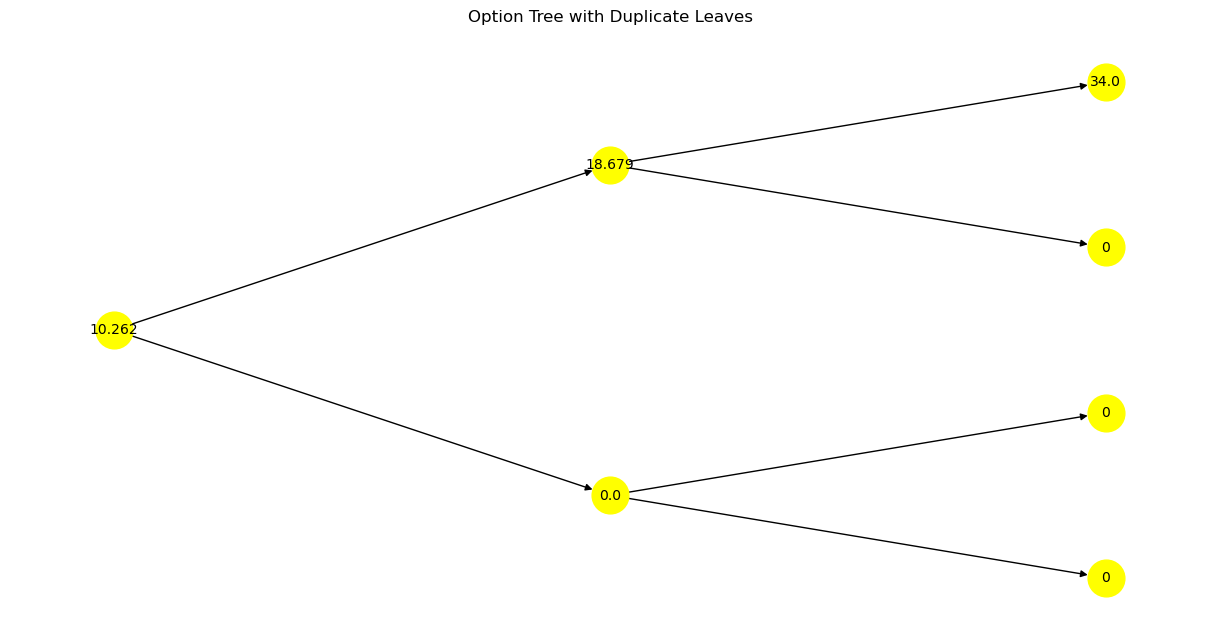

In [187]:
### TEST CELL D.N.E. ###

G = nx.DiGraph()
add_edges(G, TestOptionBTList) 

root_id = (TestOptionBTList[0], "")  

pos_vertical = hierarchy_pos(G, root_id)

pos_lr = {}
for node, (x, y) in pos_vertical.items():
    pos_lr[node] = (-y, -x)

plt.figure(figsize=(12,6))
nx.draw(G, pos_lr, with_labels=False, arrows=True, node_size=700, node_color='yellow')

labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos_lr, labels=labels, font_size=10)

plt.title("Option Tree with Duplicate Leaves")
plt.show()
